# S&P 500 Index Update Trading Strategies

## Strategy Overview

### Strategy 1: Long-Only Added Tickers
- **Capital**: $1,000,000 USD
- **Holding Period**: 30 days (configurable)
- **Entry**: Buy stocks added to S&P 500 on announcement date
- **Position Sizing**: Equal weight (1/N where N = number of concurrent positions)
- **Exit Rules**:
  - Hold for 30 days then sell
  - If new announcement comes before period ends: sell immediately and reallocate to new additions
- **Performance Metric**: Price_after_30_days / Price_at_announcement

### Strategy 2: Long/Short Pairs Trading
- **Capital**: $1,000,000 USD long + $1,000,000 USD short
- **Holding Period**: 30 days (configurable)
- **Entry**: Only trade when both Added and Removed tickers exist
  - Long: Added tickers (equal weight)
  - Short: Removed tickers (equal weight)
- **Exit Rules**: Same as Strategy 1
- **Note**: Only execute when announcement has both additions and removals

In [91]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load S&P 500 index changes data
df = pd.read_csv('./data/sp500_index_changes.csv')
df['Announcement_Date'] = pd.to_datetime(df['Announcement_Date'])
df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])

# Filter data from 2015 July onwards for sufficient data
df = df[df['Announcement_Date'] >= '2015-07-01'].reset_index(drop=True)
print(f"Number of index changes from 2015 July: {len(df)}")
df.head()

Number of index changes from 2015 July: 223


,Announcement_Date,Effective_Date,Added_Ticker,Added_Security,Removed_Ticker,Removed_Security,Reason
0,2025-07-18,2025-07-23,XYZ,"Block, Inc.",HES,Hess Corporation,S&P 500 and S&P 100 constituent Chevron Corp. ...
1,2025-07-14,2025-07-18,TTD,Trade Desk (The),ANSS,Ansys,S&P 500 constituent Synopsys Inc. acquired Ansys.
2,2025-07-02,2025-07-09,DDOG,Datadog,JNPR,Juniper Networks,S&P 500 constituent Hewlett Packard Enterprise...
3,2025-05-12,2025-05-19,COIN,Coinbase,DFS,Discover Financial,S&P 500 constituent Capital One Financial Corp...
4,2025-03-07,2025-03-24,DASH,DoorDash,BWA,BorgWarner,Market capitalization change.


In [92]:
# Strategy parameters
import os
import sys
import contextlib
from io import StringIO
from datetime import datetime as dt
import pandas_market_calendars as mcal

INITIAL_CAPITAL = 1_000_000
HOLDING_PERIOD = 22  # days

# Create log directory if it doesn't exist
os.makedirs('./log', exist_ok=True)

# Create NYSE trading calendar
nyse = mcal.get_calendar('NYSE')

def get_trading_end_date(start_date, holding_period):
    """Get the exact end date after specified number of trading days"""
    # Get trading schedule for sufficient period
    schedule = nyse.schedule(start_date=start_date, 
                            end_date=start_date + timedelta(days=holding_period * 2))
    # Get trading dates
    trading_dates = mcal.date_range(schedule, frequency='1D')
    
    if len(trading_dates) > holding_period:
        return trading_dates[holding_period].date()
    else:
        # If not enough trading days, return last available + some buffer
        return (start_date + timedelta(days=holding_period * 2)).date()

def get_stock_prices(ticker, start_date, end_date, log_file=None):
    """Get stock price data from Yahoo Finance with error logging"""
    try:
        # Capture yfinance output
        captured_output = StringIO()
        with contextlib.redirect_stderr(captured_output):
            data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
        
        # Log any yfinance errors/warnings
        captured_text = captured_output.getvalue()
        if captured_text and log_file:
            log_file.write(f"    YFinance output for {ticker}: {captured_text.strip()}\n")
        
        if data.empty:
            if log_file:
                log_file.write(f"    Warning: No data found for {ticker}\n")
            return None
        return data['Close']
    except Exception as e:
        if log_file:
            log_file.write(f"    Error fetching {ticker}: {str(e)}\n")
        return None

def calculate_strategy_returns_with_portfolio(df, holding_period=HOLDING_PERIOD, verbose=True):
    """Calculate returns for both strategies with portfolio tracking"""
    
    # Sort by announcement date (earliest first)
    df = df.sort_values('Announcement_Date').reset_index(drop=True)
    
    # Strategy 1: Long-Only Added Tickers
    strategy1_trades = []
    strategy1_portfolio_value = []
    strategy1_dates = []
    s1_capital = INITIAL_CAPITAL
    
    # Strategy 2: Long/Short Pairs
    strategy2_trades = []
    strategy2_portfolio_value = []
    strategy2_dates = []
    s2_capital = INITIAL_CAPITAL
    
    # Setup logging
    log_file = None
    if verbose:
        log_filename = f"./log/trading_log_hp{holding_period}.log"
        log_file = open(log_filename, 'w')
        
        header = f"S&P 500 Index Update Trading Strategy Analysis\n"
        header += f"Holding Period: {holding_period} trading days\n"
        header += f"Date Range: {df['Announcement_Date'].min().date()} to {df['Announcement_Date'].max().date()}\n"
        header += f"Timestamp: {dt.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        header += "="*60 + "\n"
        
        log_file.write(header)
        print(f"Logging to: {log_filename}")
        print(f"Processing {len(df)} announcements with {holding_period}-day holding period...")
    
    for idx, row in df.iterrows():
        ann_date = row['Announcement_Date']
        added_ticker = row['Added_Ticker']
        removed_ticker = row['Removed_Ticker']
        
        if verbose:
            log_file.write(f"\n{idx+1}/{len(df)}: {ann_date.date()}: Added={added_ticker}, Removed={removed_ticker}\n")
            end_date_print = get_trading_end_date(ann_date, holding_period)
            log_file.write(f"  Holding Period End Date: {end_date_print}\n")
        
        # Get exact end date using trading calendar
        end_date = get_trading_end_date(ann_date, holding_period + 1)
        
        # Strategy 1: Only if there's an added ticker
        if pd.notna(added_ticker) and added_ticker != '':
            prices = get_stock_prices(added_ticker, ann_date, end_date, log_file if verbose else None)
            if prices is not None and len(prices) >= 2:
                try:
                    entry_price = float(prices.iloc[0])
                    
                    if len(prices) > holding_period:
                        exit_price = float(prices.iloc[holding_period])
                        actual_days = holding_period
                    else:
                        exit_price = float(prices.iloc[-1])
                        actual_days = len(prices) - 1
                    
                    if entry_price > 0 and exit_price > 0:
                        return_pct = (exit_price / entry_price) - 1
                        s1_capital = s1_capital * (1 + return_pct)
                        
                        strategy1_trades.append({
                            'date': ann_date,
                            'ticker': added_ticker,
                            'return': return_pct,
                            'entry_price': entry_price,
                            'exit_price': exit_price,
                            'actual_days': actual_days
                        })
                        strategy1_portfolio_value.append(s1_capital)
                        strategy1_dates.append(ann_date)
                        
                        if verbose:
                            log_file.write(f"  ✓ S1: {added_ticker} {return_pct:.2%}, Portfolio: ${s1_capital:,.0f}\n")
                    else:
                        if verbose:
                            log_file.write(f"  ✗ S1: Invalid prices for {added_ticker}\n")
                except Exception as e:
                    if verbose:
                        log_file.write(f"  ✗ S1: Error processing {added_ticker}: {e}\n")
            else:
                if verbose:
                    log_file.write(f"  ✗ S1: Insufficient data for {added_ticker}\n")
        
        # Strategy 2: Only if both tickers exist
        if pd.notna(added_ticker) and pd.notna(removed_ticker) and added_ticker != '' and removed_ticker != '':
            added_prices = get_stock_prices(added_ticker, ann_date, end_date, log_file if verbose else None)
            removed_prices = get_stock_prices(removed_ticker, ann_date, end_date, log_file if verbose else None)
            
            if (added_prices is not None and len(added_prices) >= 2 and 
                removed_prices is not None and len(removed_prices) >= 2):
                
                try:
                    # Long position
                    added_entry = float(added_prices.iloc[0])
                    added_exit = float(added_prices.iloc[holding_period] if len(added_prices) > holding_period else added_prices.iloc[-1])
                    
                    # Short position
                    removed_entry = float(removed_prices.iloc[0])
                    removed_exit = float(removed_prices.iloc[holding_period] if len(removed_prices) > holding_period else removed_prices.iloc[-1])
                    
                    if all(price > 0 for price in [added_entry, added_exit, removed_entry, removed_exit]):
                        long_return = (added_exit / added_entry) - 1
                        short_return = (removed_entry / removed_exit) - 1
                        combined_return = 0.5 * long_return + 0.5 * short_return
                        s2_capital = s2_capital * (1 + combined_return)
                        
                        strategy2_trades.append({
                            'date': ann_date,
                            'long_ticker': added_ticker,
                            'short_ticker': removed_ticker,
                            'long_return': long_return,
                            'short_return': short_return,
                            'combined_return': combined_return
                        })
                        strategy2_portfolio_value.append(s2_capital)
                        strategy2_dates.append(ann_date)
                        
                        if verbose:
                            log_file.write(f"  ✓ S2: Long {added_ticker} ({long_return:.2%}), Short {removed_ticker} ({short_return:.2%})\n")
                            log_file.write(f"      Combined: {combined_return:.2%}, Portfolio: ${s2_capital:,.0f}\n")
                    else:
                        if verbose:
                            log_file.write(f"  ✗ S2: Invalid prices for {added_ticker}/{removed_ticker}\n")
                except Exception as e:
                    if verbose:
                        log_file.write(f"  ✗ S2: Error processing {added_ticker}/{removed_ticker}: {e}\n")
            else:
                if verbose:
                    log_file.write(f"  ✗ S2: Insufficient data for {added_ticker}/{removed_ticker}\n")
    
    if verbose:
        summary = f"\n{'='*60}\n"
        summary += f"FINAL RESULTS\n"
        summary += f"Strategy 1: {len(strategy1_trades)} successful trades, Final: ${s1_capital:,.0f} ({(s1_capital/INITIAL_CAPITAL-1)*100:.2f}%)\n"
        summary += f"Strategy 2: {len(strategy2_trades)} successful trades, Final: ${s2_capital:,.0f} ({(s2_capital/INITIAL_CAPITAL-1)*100:.2f}%)\n"
        summary += f"Completed: {dt.now().strftime('%Y-%m-%d %H:%M:%S')}\n"
        
        log_file.write(summary)
        log_file.close()
        print(summary)
    
    # Create portfolio DataFrames
    s1_portfolio_df = pd.DataFrame({
        'date': strategy1_dates,
        'portfolio_value': strategy1_portfolio_value
    }) if strategy1_dates else pd.DataFrame()
    
    s2_portfolio_df = pd.DataFrame({
        'date': strategy2_dates,
        'portfolio_value': strategy2_portfolio_value
    }) if strategy2_dates else pd.DataFrame()
    
    return (strategy1_trades, s1_portfolio_df, strategy2_trades, s2_portfolio_df)

# Execute strategies
s1_trades, s1_portfolio, s2_trades, s2_portfolio = calculate_strategy_returns_with_portfolio(df)

Logging to: ./log/trading_log_hp22.log
Processing 223 announcements with 22-day holding period...

FINAL RESULTS
Strategy 1: 186 successful trades, Final: $2,049,768 (104.98%)
Strategy 2: 82 successful trades, Final: $1,404,459 (40.45%)
Completed: 2025-08-23 19:07:14



In [93]:
# Calculate portfolio performance metrics and Sharpe ratio
def calculate_sharpe_ratio(portfolio_df, risk_free_rate=0.02):
    """Calculate Sharpe ratio from portfolio values"""
    if portfolio_df.empty or len(portfolio_df) < 2:
        return 0
    
    # Calculate daily returns
    portfolio_df = portfolio_df.sort_values('date')
    returns = portfolio_df['portfolio_value'].pct_change().dropna()
    
    if len(returns) == 0:
        return 0
    
    # Annualized Sharpe ratio (assuming 252 trading days)
    excess_returns = returns - risk_free_rate/252
    if excess_returns.std() > 0:
        sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    else:
        sharpe = 0
    
    return sharpe

def calculate_max_drawdown(portfolio_df):
    """Calculate maximum drawdown"""
    if portfolio_df.empty:
        return 0
    
    portfolio_values = portfolio_df['portfolio_value'].values
    running_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - running_max) / running_max
    return drawdowns.min()

# Calculate metrics for both strategies
s1_final_value = s1_portfolio['portfolio_value'].iloc[-1] if not s1_portfolio.empty else INITIAL_CAPITAL
s1_total_return = (s1_final_value / INITIAL_CAPITAL - 1) * 100
s1_sharpe = calculate_sharpe_ratio(s1_portfolio)
s1_max_dd = calculate_max_drawdown(s1_portfolio) * 100
s1_win_rate = sum(1 for t in s1_trades if t['return'] > 0) / len(s1_trades) * 100 if s1_trades else 0

s2_final_value = s2_portfolio['portfolio_value'].iloc[-1] if not s2_portfolio.empty else INITIAL_CAPITAL
s2_total_return = (s2_final_value / INITIAL_CAPITAL - 1) * 100
s2_sharpe = calculate_sharpe_ratio(s2_portfolio)
s2_max_dd = calculate_max_drawdown(s2_portfolio) * 100
s2_win_rate = sum(1 for t in s2_trades if t['combined_return'] > 0) / len(s2_trades) * 100 if s2_trades else 0

# Display performance summary
print("\n" + "="*70)
print("PORTFOLIO PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Metric':<30} {'Strategy 1':<20} {'Strategy 2':<20}")
print("-"*70)
print(f"{'Initial Capital':<30} ${INITIAL_CAPITAL:,.0f}{'':>10} ${INITIAL_CAPITAL:,.0f}{'':>10}")
print(f"{'Final Portfolio Value':<30} ${s1_final_value:,.0f}{'':>10} ${s2_final_value:,.0f}{'':>10}")
print(f"{'Total Return':<30} {s1_total_return:.2f}%{'':>13} {s2_total_return:.2f}%{'':>13}")
print(f"{'Sharpe Ratio':<30} {s1_sharpe:.2f}{'':>17} {s2_sharpe:.2f}{'':>17}")
print(f"{'Max Drawdown':<30} {s1_max_dd:.2f}%{'':>13} {s2_max_dd:.2f}%{'':>13}")
print(f"{'Number of Trades':<30} {len(s1_trades):<20} {len(s2_trades):<20}")
print(f"{'Win Rate':<30} {s1_win_rate:.1f}%{'':>14} {s2_win_rate:.1f}%{'':>14}")

if s1_trades:
    avg_return_s1 = np.mean([t['return'] for t in s1_trades]) * 100
    std_return_s1 = np.std([t['return'] for t in s1_trades]) * 100
    best_trade_s1 = max(t['return'] for t in s1_trades) * 100
    worst_trade_s1 = min(t['return'] for t in s1_trades) * 100
    
    print(f"{'Avg Return per Trade':<30} {avg_return_s1:.2f}%{'':>13} ", end="")
else:
    print(f"{'Avg Return per Trade':<30} {'N/A':<20} ", end="")

if s2_trades:
    avg_return_s2 = np.mean([t['combined_return'] for t in s2_trades]) * 100
    std_return_s2 = np.std([t['combined_return'] for t in s2_trades]) * 100
    best_trade_s2 = max(t['combined_return'] for t in s2_trades) * 100
    worst_trade_s2 = min(t['combined_return'] for t in s2_trades) * 100
    
    print(f"{avg_return_s2:.2f}%")
    print(f"{'Std Dev per Trade':<30} {std_return_s1:.2f}%{'':>13} {std_return_s2:.2f}%")
    print(f"{'Best Trade':<30} {best_trade_s1:.2f}%{'':>13} {best_trade_s2:.2f}%")
    print(f"{'Worst Trade':<30} {worst_trade_s1:.2f}%{'':>13} {worst_trade_s2:.2f}%")
else:
    print("N/A")

print("="*70)


PORTFOLIO PERFORMANCE SUMMARY
Metric                         Strategy 1           Strategy 2          
----------------------------------------------------------------------
Initial Capital                $1,000,000           $1,000,000          
Final Portfolio Value          $2,049,768           $1,404,459          
Total Return                   104.98%              40.45%             
Sharpe Ratio                   1.34                  1.29                 
Max Drawdown                   -75.84%              -59.91%             
Number of Trades               186                  82                  
Win Rate                       50.5%               51.2%              
Avg Return per Trade           1.00%              0.73%
Std Dev per Trade              11.27%              7.87%
Best Trade                     43.97%              23.84%
Worst Trade                    -29.34%              -21.87%


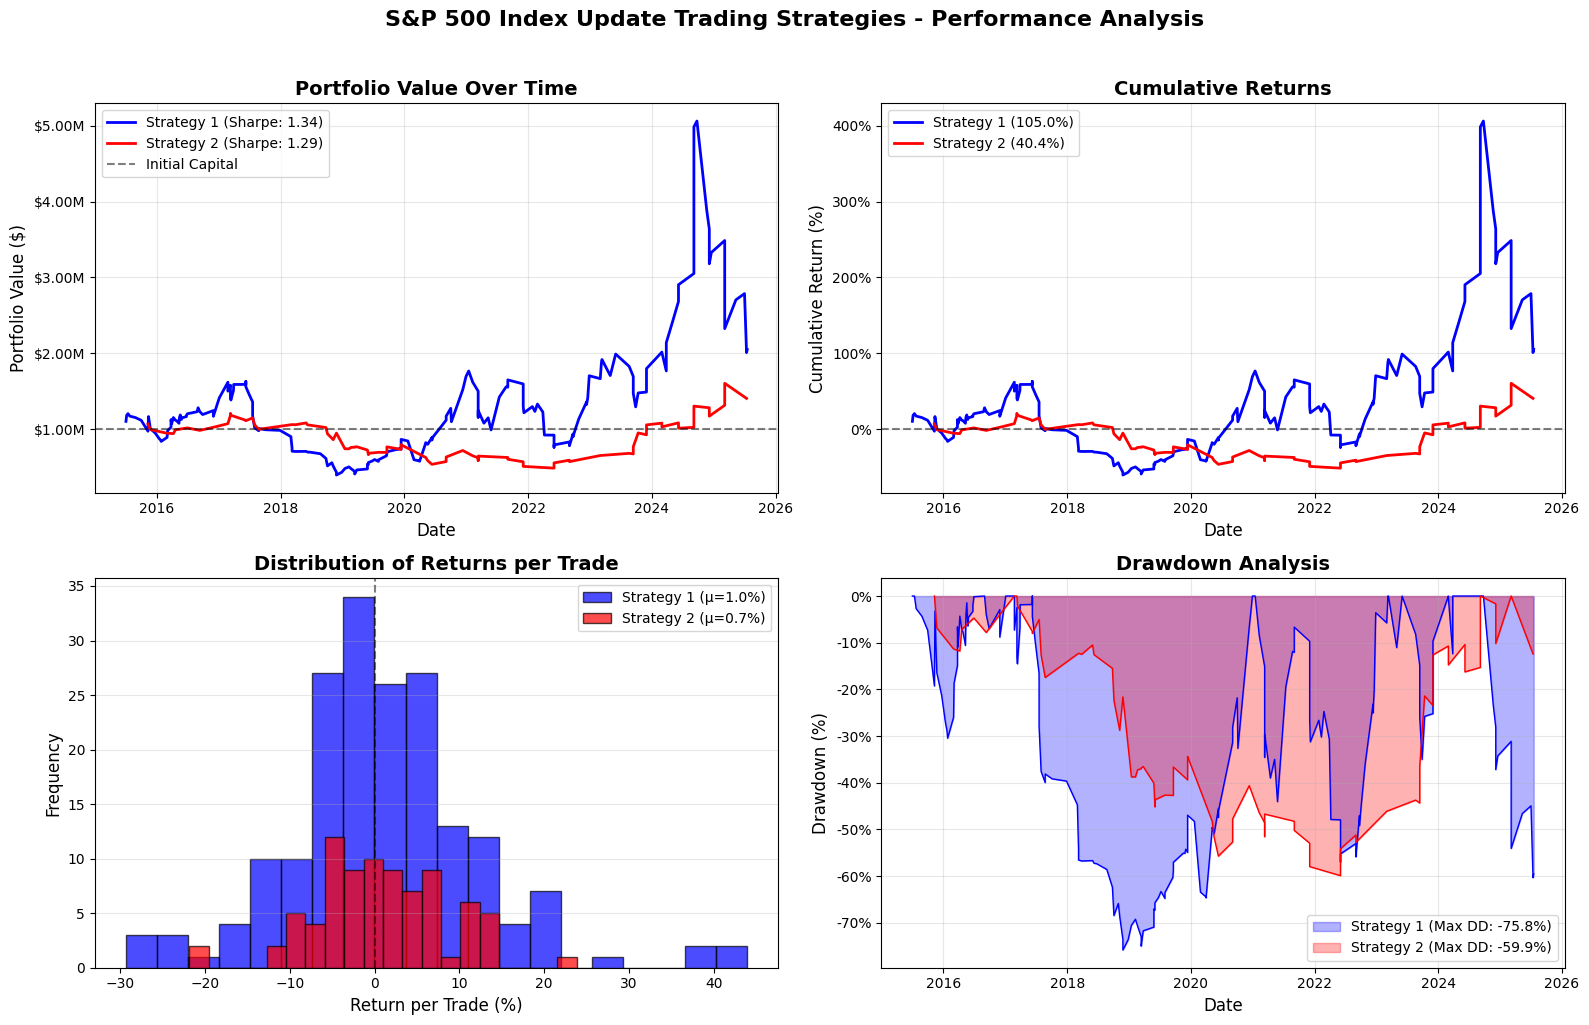


TOP 5 TRADES

Strategy 1 - Best Trades:
  1. MRNA   on 2021-07-15:  43.97%
  2. HWM    on 2020-05-05:  40.54%
  3. TSLA   on 2020-12-11:  38.53%
  4. PLTR   on 2024-09-06:  36.66%
  5. ETSY   on 2020-09-04:  27.33%

Strategy 2 - Best Trades:
  1. Long HUBB   / Short OGN    on 2023-10-13:  23.84%
  2. Long KDP    / Short UAA    on 2022-06-03:  14.38%
  3. Long FICO   / Short LUMN   on 2023-03-03:  14.10%
  4. Long ABNB   / Short NWL    on 2023-09-14:  14.07%
  5. Long PLTR   / Short AAL    on 2024-09-06:  13.63%

WORST 5 TRADES

Strategy 1 - Worst Trades:
  1. IR     on 2020-02-27: -29.34%
  2. TTD    on 2025-07-14: -27.93%
  3. WSM    on 2025-03-07: -26.11%
  4. WBD    on 2022-04-07: -24.79%
  5. TPL    on 2024-11-21: -23.30%

Strategy 2 - Worst Trades:
  1. Long TFX    / Short PCG    on 2019-01-15: -21.87%
  2. Long DPZ    / Short CPRI   on 2020-05-06: -21.10%
  3. Long TTD    / Short ANSS   on 2025-07-14: -12.42%
  4. Long SEDG   / Short HBI    on 2021-12-03: -10.67%
  5. Long MPWR 

In [94]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Portfolio Value Over Time
ax1 = axes[0, 0]
if not s1_portfolio.empty:
    ax1.plot(s1_portfolio['date'], s1_portfolio['portfolio_value'], 
             label=f'Strategy 1 (Sharpe: {s1_sharpe:.2f})', linewidth=2, color='blue')
if not s2_portfolio.empty:
    ax1.plot(s2_portfolio['date'], s2_portfolio['portfolio_value'], 
             label=f'Strategy 2 (Sharpe: {s2_sharpe:.2f})', linewidth=2, color='red')

ax1.axhline(y=INITIAL_CAPITAL, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.2f}M'))

# 2. Cumulative Returns
ax2 = axes[0, 1]
if not s1_portfolio.empty:
    s1_cum_returns = (s1_portfolio['portfolio_value'] / INITIAL_CAPITAL - 1) * 100
    ax2.plot(s1_portfolio['date'], s1_cum_returns, 
             label=f'Strategy 1 ({s1_total_return:.1f}%)', linewidth=2, color='blue')
if not s2_portfolio.empty:
    s2_cum_returns = (s2_portfolio['portfolio_value'] / INITIAL_CAPITAL - 1) * 100
    ax2.plot(s2_portfolio['date'], s2_cum_returns, 
             label=f'Strategy 2 ({s2_total_return:.1f}%)', linewidth=2, color='red')

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Cumulative Return (%)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

# 3. Returns Distribution
ax3 = axes[1, 0]
if s1_trades:
    s1_returns = [t['return'] * 100 for t in s1_trades]
    ax3.hist(s1_returns, bins=20, alpha=0.7, 
             label=f'Strategy 1 (μ={np.mean(s1_returns):.1f}%)', color='blue', edgecolor='black')
if s2_trades:
    s2_returns = [t['combined_return'] * 100 for t in s2_trades]
    ax3.hist(s2_returns, bins=20, alpha=0.7, 
             label=f'Strategy 2 (μ={np.mean(s2_returns):.1f}%)', color='red', edgecolor='black')

ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3.set_title('Distribution of Returns per Trade', fontsize=14, fontweight='bold')
ax3.set_xlabel('Return per Trade (%)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Drawdown Analysis
ax4 = axes[1, 1]
if not s1_portfolio.empty:
    s1_values = s1_portfolio['portfolio_value'].values
    s1_running_max = np.maximum.accumulate(s1_values)
    s1_drawdown = (s1_values - s1_running_max) / s1_running_max * 100
    ax4.fill_between(s1_portfolio['date'], 0, s1_drawdown, 
                     alpha=0.3, color='blue', label=f'Strategy 1 (Max DD: {s1_max_dd:.1f}%)')
    ax4.plot(s1_portfolio['date'], s1_drawdown, linewidth=1, color='blue')

if not s2_portfolio.empty:
    s2_values = s2_portfolio['portfolio_value'].values
    s2_running_max = np.maximum.accumulate(s2_values)
    s2_drawdown = (s2_values - s2_running_max) / s2_running_max * 100
    ax4.fill_between(s2_portfolio['date'], 0, s2_drawdown, 
                     alpha=0.3, color='red', label=f'Strategy 2 (Max DD: {s2_max_dd:.1f}%)')
    ax4.plot(s2_portfolio['date'], s2_drawdown, linewidth=1, color='red')

ax4.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Drawdown (%)', fontsize=12)
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

plt.suptitle('S&P 500 Index Update Trading Strategies - Performance Analysis', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print top and bottom trades
print("\n" + "="*70)
print("TOP 5 TRADES")
print("="*70)

if s1_trades:
    print("\nStrategy 1 - Best Trades:")
    s1_sorted = sorted(s1_trades, key=lambda x: x['return'], reverse=True)[:5]
    for i, trade in enumerate(s1_sorted, 1):
        print(f"  {i}. {trade['ticker']:<6} on {trade['date'].date()}: {trade['return']*100:>6.2f}%")

if s2_trades:
    print("\nStrategy 2 - Best Trades:")
    s2_sorted = sorted(s2_trades, key=lambda x: x['combined_return'], reverse=True)[:5]
    for i, trade in enumerate(s2_sorted, 1):
        print(f"  {i}. Long {trade['long_ticker']:<6} / Short {trade['short_ticker']:<6} on {trade['date'].date()}: {trade['combined_return']*100:>6.2f}%")

print("\n" + "="*70)
print("WORST 5 TRADES")
print("="*70)

if s1_trades:
    print("\nStrategy 1 - Worst Trades:")
    s1_worst = sorted(s1_trades, key=lambda x: x['return'])[:5]
    for i, trade in enumerate(s1_worst, 1):
        print(f"  {i}. {trade['ticker']:<6} on {trade['date'].date()}: {trade['return']*100:>6.2f}%")

if s2_trades:
    print("\nStrategy 2 - Worst Trades:")
    s2_worst = sorted(s2_trades, key=lambda x: x['combined_return'])[:5]
    for i, trade in enumerate(s2_worst, 1):
        print(f"  {i}. Long {trade['long_ticker']:<6} / Short {trade['short_ticker']:<6} on {trade['date'].date()}: {trade['combined_return']*100:>6.2f}%")

print("="*70)

In [95]:
# Test different holding periods (1-22 trading days)
print("Testing different holding periods...")
print("This will take several minutes as we need to fetch data for each period.")
print("="*70)

holding_periods = list(range(1, 23))  # 1 to 22 trading days
results = {
    's1_returns': [],
    's1_sharpe': [],
    's2_returns': [],
    's2_sharpe': [],
    'periods': holding_periods
}

# Helper function to calculate Sharpe ratio
def quick_sharpe(portfolio_df, risk_free_rate=0.02):
    """Quick Sharpe calculation"""
    if portfolio_df.empty or len(portfolio_df) < 2:
        return 0
    
    returns = portfolio_df['portfolio_value'].pct_change().dropna()
    if len(returns) == 0 or returns.std() == 0:
        return 0
    
    excess_returns = returns - risk_free_rate/252
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# Test each holding period
for hp in holding_periods:
    print(f"Testing holding period: {hp} days...", end=" ")
    
    # Run strategies without verbose output
    s1_trades_hp, s1_portfolio_hp, s2_trades_hp, s2_portfolio_hp = \
        calculate_strategy_returns_with_portfolio(df, holding_period=hp, verbose=True)
    
    # Calculate returns
    s1_return = (s1_portfolio_hp['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not s1_portfolio_hp.empty else 0
    s2_return = (s2_portfolio_hp['portfolio_value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100 if not s2_portfolio_hp.empty else 0
    
    # Calculate Sharpe ratios
    s1_sharpe_hp = quick_sharpe(s1_portfolio_hp)
    s2_sharpe_hp = quick_sharpe(s2_portfolio_hp)
    
    results['s1_returns'].append(s1_return)
    results['s1_sharpe'].append(s1_sharpe_hp)
    results['s2_returns'].append(s2_return)
    results['s2_sharpe'].append(s2_sharpe_hp)
    
    print(f"S1: {s1_return:.1f}% (Sharpe: {s1_sharpe_hp:.2f}), S2: {s2_return:.1f}% (Sharpe: {s2_sharpe_hp:.2f})")

# Create DataFrame for results
results_df = pd.DataFrame({
    'Holding Period': holding_periods,
    'Strategy 1 Return (%)': results['s1_returns'],
    'Strategy 1 Sharpe': results['s1_sharpe'],
    'Strategy 2 Return (%)': results['s2_returns'],
    'Strategy 2 Sharpe': results['s2_sharpe']
})


Testing different holding periods...
This will take several minutes as we need to fetch data for each period.
Testing holding period: 1 days... Logging to: ./log/trading_log_hp1.log
Processing 223 announcements with 1-day holding period...

FINAL RESULTS
Strategy 1: 170 successful trades, Final: $9,717,956 (871.80%)
Strategy 2: 75 successful trades, Final: $1,292,769 (29.28%)
Completed: 2025-08-23 19:15:24

S1: 871.8% (Sharpe: 4.62), S2: 29.3% (Sharpe: 2.48)
Testing holding period: 2 days... Logging to: ./log/trading_log_hp2.log
Processing 223 announcements with 2-day holding period...

FINAL RESULTS
Strategy 1: 184 successful trades, Final: $6,205,441 (520.54%)
Strategy 2: 82 successful trades, Final: $1,214,943 (21.49%)
Completed: 2025-08-23 19:23:21

S1: 520.5% (Sharpe: 3.10), S2: 21.5% (Sharpe: 1.57)
Testing holding period: 3 days... Logging to: ./log/trading_log_hp3.log
Processing 223 announcements with 3-day holding period...

FINAL RESULTS
Strategy 1: 184 successful trades, Fina

In [96]:
print("\n" + "="*70)
print("HOLDING PERIOD OPTIMIZATION RESULTS")
print("="*70)

# Find optimal holding periods
s1_best_return_hp = results_df.loc[results_df['Strategy 1 Return (%)'].idxmax(), 'Holding Period']
s1_best_sharpe_hp = results_df.loc[results_df['Strategy 1 Sharpe'].idxmax(), 'Holding Period']
s2_best_return_hp = results_df.loc[results_df['Strategy 2 Return (%)'].idxmax(), 'Holding Period']
s2_best_sharpe_hp = results_df.loc[results_df['Strategy 2 Sharpe'].idxmax(), 'Holding Period']

print(f"\nStrategy 1:")
print(f"  Best Return: {results_df['Strategy 1 Return (%)'].max():.2f}% at {int(s1_best_return_hp)} days")
print(f"  Best Sharpe: {results_df['Strategy 1 Sharpe'].max():.2f} at {int(s1_best_sharpe_hp)} days")

print(f"\nStrategy 2:")
print(f"  Best Return: {results_df['Strategy 2 Return (%)'].max():.2f}% at {int(s2_best_return_hp)} days")
print(f"  Best Sharpe: {results_df['Strategy 2 Sharpe'].max():.2f} at {int(s2_best_sharpe_hp)} days")

# Display top 5 holding periods by Sharpe ratio
print("\nTop 5 Holding Periods by Sharpe Ratio:")
print("\nStrategy 1:")
top5_s1 = results_df.nlargest(5, 'Strategy 1 Sharpe')[['Holding Period', 'Strategy 1 Return (%)', 'Strategy 1 Sharpe']]
for idx, row in top5_s1.iterrows():
    hp = int(row['Holding Period'])
    ret = row['Strategy 1 Return (%)']
    sharpe = row['Strategy 1 Sharpe']
    print(f"  {hp:2d} days: Return = {ret:6.2f}%, Sharpe = {sharpe:.2f}")

print("\nStrategy 2:")
top5_s2 = results_df.nlargest(5, 'Strategy 2 Sharpe')[['Holding Period', 'Strategy 2 Return (%)', 'Strategy 2 Sharpe']]
for idx, row in top5_s2.iterrows():
    hp = int(row['Holding Period'])
    ret = row['Strategy 2 Return (%)']
    sharpe = row['Strategy 2 Sharpe']
    print(f"  {hp:2d} days: Return = {ret:6.2f}%, Sharpe = {sharpe:.2f}")


HOLDING PERIOD OPTIMIZATION RESULTS

Strategy 1:
  Best Return: 871.80% at 1 days
  Best Sharpe: 4.62 at 1 days

Strategy 2:
  Best Return: 117.75% at 16 days
  Best Sharpe: 2.76 at 16 days

Top 5 Holding Periods by Sharpe Ratio:

Strategy 1:
   1 days: Return = 871.80%, Sharpe = 4.62
   3 days: Return = 562.49%, Sharpe = 3.29
   2 days: Return = 520.54%, Sharpe = 3.10
   4 days: Return = 650.59%, Sharpe = 3.00
   5 days: Return = 440.88%, Sharpe = 2.47

Strategy 2:
  16 days: Return = 117.75%, Sharpe = 2.76
   1 days: Return =  29.28%, Sharpe = 2.48
  17 days: Return =  92.07%, Sharpe = 2.44
   3 days: Return =  42.20%, Sharpe = 2.30
  18 days: Return =  85.13%, Sharpe = 2.19


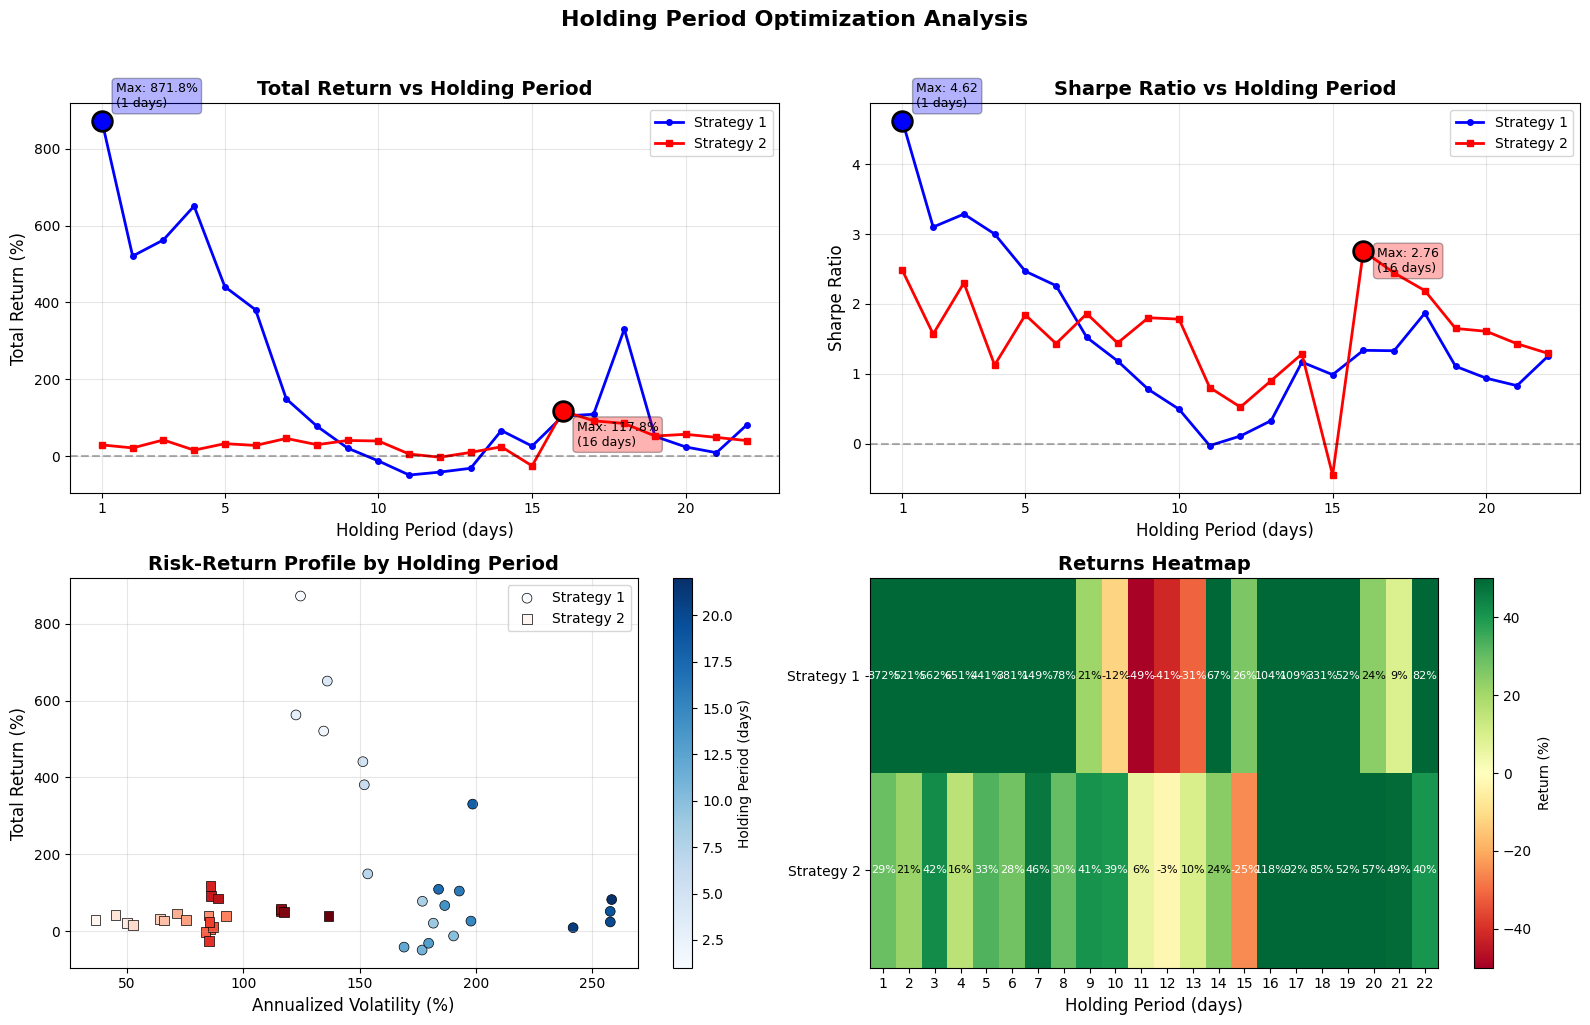


Results saved to: ./log/holding_period_analysis.csv

SUMMARY STATISTICS ACROSS ALL HOLDING PERIODS

Strategy 1:
  Mean Return: 197.45%
  Std Dev Return: 255.26%
  Mean Sharpe: 1.54
  Holding periods with positive returns: 18/22

Strategy 2:
  Mean Return: 37.78%
  Std Dev Return: 30.90%
  Mean Sharpe: 1.55
  Holding periods with positive returns: 20/22

Recommendation:
  Strategy 1 with 1-day holding period offers the best risk-adjusted returns


In [97]:
# Visualize holding period analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Total Returns vs Holding Period
ax1 = axes[0, 0]
ax1.plot(holding_periods, results['s1_returns'], marker='o', linewidth=2, 
         label='Strategy 1', color='blue', markersize=4)
ax1.plot(holding_periods, results['s2_returns'], marker='s', linewidth=2, 
         label='Strategy 2', color='red', markersize=4)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax1.set_xlabel('Holding Period (days)', fontsize=12)
ax1.set_ylabel('Total Return (%)', fontsize=12)
ax1.set_title('Total Return vs Holding Period', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks([1, 5, 10, 15, 20, 25, 30])

# Mark best points
s1_max_idx = np.argmax(results['s1_returns'])
s2_max_idx = np.argmax(results['s2_returns'])
ax1.scatter(holding_periods[s1_max_idx], results['s1_returns'][s1_max_idx], 
           color='blue', s=200, zorder=5, edgecolors='black', linewidth=2)
ax1.scatter(holding_periods[s2_max_idx], results['s2_returns'][s2_max_idx], 
           color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax1.annotate(f'Max: {results["s1_returns"][s1_max_idx]:.1f}%\n({holding_periods[s1_max_idx]} days)', 
            xy=(holding_periods[s1_max_idx], results['s1_returns'][s1_max_idx]),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))
ax1.annotate(f'Max: {results["s2_returns"][s2_max_idx]:.1f}%\n({holding_periods[s2_max_idx]} days)', 
            xy=(holding_periods[s2_max_idx], results['s2_returns'][s2_max_idx]),
            xytext=(10, -25), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

# 2. Sharpe Ratio vs Holding Period
ax2 = axes[0, 1]
ax2.plot(holding_periods, results['s1_sharpe'], marker='o', linewidth=2, 
         label='Strategy 1', color='blue', markersize=4)
ax2.plot(holding_periods, results['s2_sharpe'], marker='s', linewidth=2, 
         label='Strategy 2', color='red', markersize=4)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Holding Period (days)', fontsize=12)
ax2.set_ylabel('Sharpe Ratio', fontsize=12)
ax2.set_title('Sharpe Ratio vs Holding Period', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xticks([1, 5, 10, 15, 20, 25, 30])

# Mark best Sharpe points
s1_sharpe_max_idx = np.argmax(results['s1_sharpe'])
s2_sharpe_max_idx = np.argmax(results['s2_sharpe'])
ax2.scatter(holding_periods[s1_sharpe_max_idx], results['s1_sharpe'][s1_sharpe_max_idx], 
           color='blue', s=200, zorder=5, edgecolors='black', linewidth=2)
ax2.scatter(holding_periods[s2_sharpe_max_idx], results['s2_sharpe'][s2_sharpe_max_idx], 
           color='red', s=200, zorder=5, edgecolors='black', linewidth=2)
ax2.annotate(f'Max: {results["s1_sharpe"][s1_sharpe_max_idx]:.2f}\n({holding_periods[s1_sharpe_max_idx]} days)', 
            xy=(holding_periods[s1_sharpe_max_idx], results['s1_sharpe'][s1_sharpe_max_idx]),
            xytext=(10, 10), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3))
ax2.annotate(f'Max: {results["s2_sharpe"][s2_sharpe_max_idx]:.2f}\n({holding_periods[s2_sharpe_max_idx]} days)', 
            xy=(holding_periods[s2_sharpe_max_idx], results['s2_sharpe'][s2_sharpe_max_idx]),
            xytext=(10, -15), textcoords='offset points', fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3))

# 3. Return/Risk Trade-off
ax3 = axes[1, 0]
# Calculate risk (std dev) for each holding period
s1_risks = []
s2_risks = []
for hp in holding_periods:
    s1_trades_hp, s1_portfolio_hp, s2_trades_hp, s2_portfolio_hp = \
        calculate_strategy_returns_with_portfolio(df.head(20), holding_period=hp, verbose=False)  # Use subset for speed
    
    if not s1_portfolio_hp.empty and len(s1_portfolio_hp) > 1:
        s1_risks.append(s1_portfolio_hp['portfolio_value'].pct_change().std() * np.sqrt(252) * 100)
    else:
        s1_risks.append(0)
    
    if not s2_portfolio_hp.empty and len(s2_portfolio_hp) > 1:
        s2_risks.append(s2_portfolio_hp['portfolio_value'].pct_change().std() * np.sqrt(252) * 100)
    else:
        s2_risks.append(0)

# Create scatter plot with color gradient for holding period
scatter1 = ax3.scatter(s1_risks, results['s1_returns'], c=holding_periods, 
                       cmap='Blues', s=50, label='Strategy 1', edgecolors='black', linewidth=0.5)
scatter2 = ax3.scatter(s2_risks, results['s2_returns'], c=holding_periods, 
                       cmap='Reds', s=50, label='Strategy 2', marker='s', edgecolors='black', linewidth=0.5)
ax3.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax3.set_ylabel('Total Return (%)', fontsize=12)
ax3.set_title('Risk-Return Profile by Holding Period', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax3, label='Holding Period (days)')

# 4. Heatmap of returns
ax4 = axes[1, 1]
# Create a comparison matrix
comparison_data = np.array([results['s1_returns'], results['s2_returns']])
im = ax4.imshow(comparison_data, cmap='RdYlGn', aspect='auto', vmin=-50, vmax=50)
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['Strategy 1', 'Strategy 2'])

# Set x-ticks based on actual holding periods
num_periods = len(holding_periods)
ax4.set_xticks(range(num_periods))
ax4.set_xticklabels(holding_periods)
ax4.set_xlabel('Holding Period (days)', fontsize=12)
ax4.set_title('Returns Heatmap', fontsize=14, fontweight='bold')

# Add text annotations for all holding periods
for i in range(num_periods):
    ax4.text(i, 0, f'{results["s1_returns"][i]:.0f}%', ha='center', va='center', fontsize=8, 
             color='white' if abs(results["s1_returns"][i]) > 25 else 'black')
    ax4.text(i, 1, f'{results["s2_returns"][i]:.0f}%', ha='center', va='center', fontsize=8, 
             color='white' if abs(results["s2_returns"][i]) > 25 else 'black')

plt.colorbar(im, ax=ax4, label='Return (%)')

plt.suptitle('Holding Period Optimization Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Save results to CSV for future reference
results_df.to_csv('./log/holding_period_analysis.csv', index=False)
print(f"\nResults saved to: ./log/holding_period_analysis.csv")

# Display summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS ACROSS ALL HOLDING PERIODS")
print("="*70)
print(f"\nStrategy 1:")
print(f"  Mean Return: {np.mean(results['s1_returns']):.2f}%")
print(f"  Std Dev Return: {np.std(results['s1_returns']):.2f}%")
print(f"  Mean Sharpe: {np.mean(results['s1_sharpe']):.2f}")
print(f"  Holding periods with positive returns: {sum(1 for r in results['s1_returns'] if r > 0)}/{num_periods}")

print(f"\nStrategy 2:")
print(f"  Mean Return: {np.mean(results['s2_returns']):.2f}%")
print(f"  Std Dev Return: {np.std(results['s2_returns']):.2f}%")
print(f"  Mean Sharpe: {np.mean(results['s2_sharpe']):.2f}")
print(f"  Holding periods with positive returns: {sum(1 for r in results['s2_returns'] if r > 0)}/{num_periods}")

print("\nRecommendation:")
if results_df['Strategy 1 Sharpe'].max() > results_df['Strategy 2 Sharpe'].max():
    print(f"  Strategy 1 with {s1_best_sharpe_hp}-day holding period offers the best risk-adjusted returns")
else:
    print(f"  Strategy 2 with {s2_best_sharpe_hp}-day holding period offers the best risk-adjusted returns")
print("="*70)